# Human-Robot Classification


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import timeit
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image
import glob
import os
from tqdm import tqdm
import utils

In [2]:
NUM_DATA = 960
TRAIN_DATA_DIR = "data/training_data"
VAL_DATA_DIR = "data/validation_data"
BATCH_SIZE = 16
num_classes = 2
stats = {}

In [3]:
utils.set_random_seed(42)

## Loading the Dataset

In [4]:
X,y = utils.load_dataset(root_dir=TRAIN_DATA_DIR)
print("X.shape:{} y.shape:{}".format(X.shape, y.shape))

/home/cansu/Desktop/CANSU/Projects/RobotHumanClassification/utils.py:60: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(data), np.array(label)


X.shape:(864,) y.shape:(864,)


/home/cansu/Desktop/CANSU/Projects/RobotHumanClassification/utils.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), np.array(label)


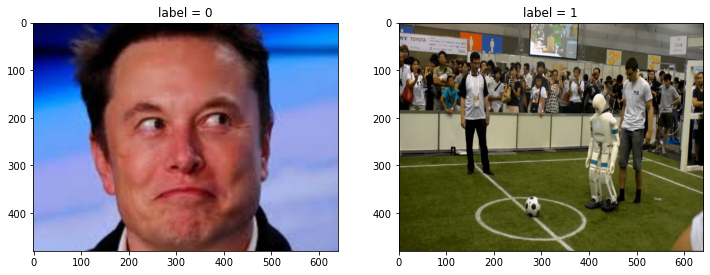

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].imshow(X[1])
_=axs[0].set_title("label = " + str(y[1]))

axs[1].imshow(X[500])
_=axs[1].set_title("label = " + str(y[500]))

## Transforms

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(244),
        transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomResizedCrop(size=(244,244)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(244),
        transforms.ToTensor(),
    ]),
    'train_cutmix': transforms.Compose([
        transforms.Resize(244),
        transforms.ToTensor(),
    ]),
}

## Dataset Class - Online Data Augmentation

In [7]:
class Dataset():
    def __init__(self, root_dir="data", transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.images, self.labels = utils.load_dataset(root_dir=root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label
    
train_dataset = Dataset(root_dir=TRAIN_DATA_DIR, transform=data_transforms["train"])
val_dataset = Dataset(root_dir=VAL_DATA_DIR, transform=data_transforms["val"])   

## Visualize Augmented Data

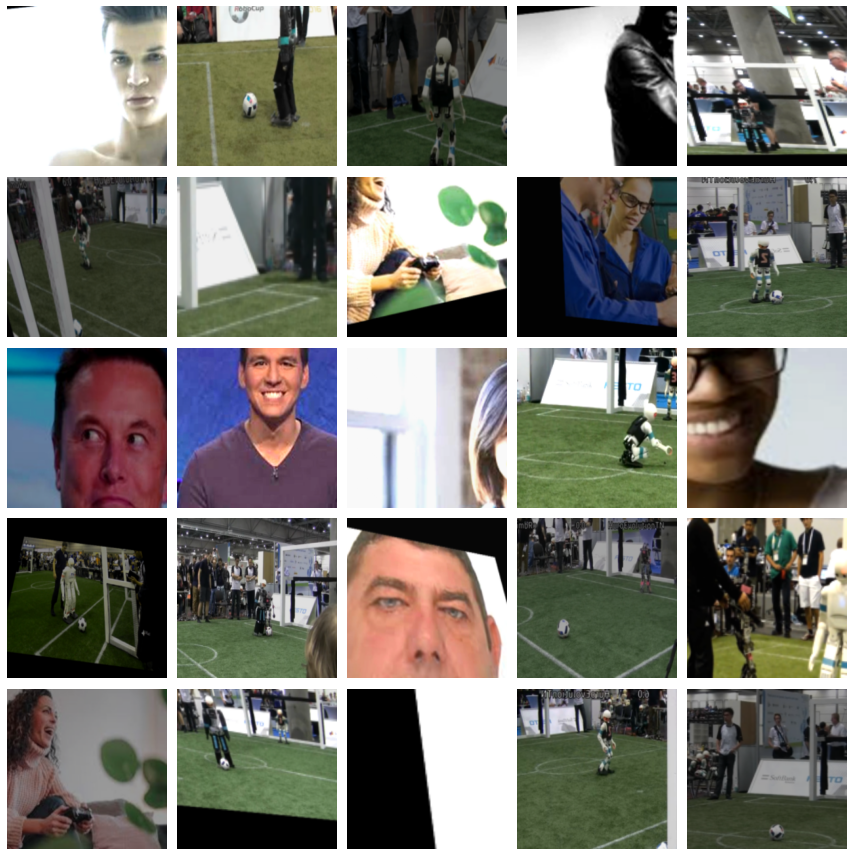

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

fig, axs = plt.subplots(5,5, figsize=(12,12))

axs = np.array(axs).flatten().tolist()

for idx, (img, label) in enumerate(train_loader):
    if idx==25:
        break
    axs[idx].imshow(img[0].permute(1,2,0))
    axs[idx].axis('off')
    
fig.tight_layout()

## Dataloader

In [9]:
print("Single Sample Shape: {}\n".format(train_dataset[0][0].size()))

print("Data sizes: \nTrain data size = {} \nValidation data size = {}\n".format(len(train_dataset),len(val_dataset)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
#test_loader = DataLoader(testset, BATCH_SIZE)

print("Total number of batches in one epoch (Train):", len(train_loader))
print("Total number of batches in one epoch (Validation):", len(val_loader))
#print("Total number of batches in one epoch (Test):", len(test_loader))

Single Sample Shape: torch.Size([3, 244, 244])

Data sizes: 
Train data size = 864 
Validation data size = 24

Total number of batches in one epoch (Train): 54
Total number of batches in one epoch (Validation): 2


## Set the Training Device

In [10]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Wed Jul 13 19:49:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P8    15W /  N/A |   5035MiB / 16384MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Filter Parameters Require Grad

In [11]:
#params_to_update = create_params_to_update(model, feature_extract, debug=True)
#Observe that all parameters are being optimized
#optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

## Initialize Model

In [12]:
# Models to choose from [resnet, vgg, densenet]
#model_name = "vgg"

# Initialize the model for this run
#model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

# Send the model to GPU
#model_ft = model_ft.to(device)

## Hyperparameters

In [13]:
# Number of epochs to train for
num_epochs = 200

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

## Experiments (Feature Extract)

### VGG

In [14]:
# Initialize the model for this run
model = utils.initialize_model("vgg", num_classes, feature_extract, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss() # Setup the loss
params_to_update = utils.create_params_to_update(model, feature_extract)
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

# Print the model we just initialized
from pytorch_model_summary import summary
print( summary(model, torch.zeros((1, 3, 400, 400)).to(device), show_input=True) )

with open('VGG_model.txt', 'w') as f:
    print(model, file=f)
    
#print(model)  #prints the model in detail

-------------------------------------------------------------------------------
           Layer (type)            Input Shape         Param #     Tr. Param #
               Conv2d-1       [1, 3, 400, 400]           1,792               0
          BatchNorm2d-2      [1, 64, 400, 400]             128               0
                 ReLU-3      [1, 64, 400, 400]               0               0
            MaxPool2d-4      [1, 64, 400, 400]               0               0
               Conv2d-5      [1, 64, 200, 200]          73,856               0
          BatchNorm2d-6     [1, 128, 200, 200]             256               0
                 ReLU-7     [1, 128, 200, 200]               0               0
            MaxPool2d-8     [1, 128, 200, 200]               0               0
               Conv2d-9     [1, 128, 100, 100]         295,168               0
         BatchNorm2d-10     [1, 256, 100, 100]             512               0
                ReLU-11     [1, 256, 100, 100]     

In [15]:
# Train and evaluate
training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist = utils.train(model,
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               optimizer, 
                                                                               criterion, 
                                                                               max_epoch=num_epochs, 
                                                                               device=device, 
                                                                               debug=False)

stats["vgg_feature_ext"] = (training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist)

epoch 199 train loss:0.0217 train acc:0.99537 val loss:0.01049 val acc:1.0: 100%|████████████████████████████████████████████████| 200/200 [31:24<00:00,  9.42s/it]

Time:  1884.6116579300724


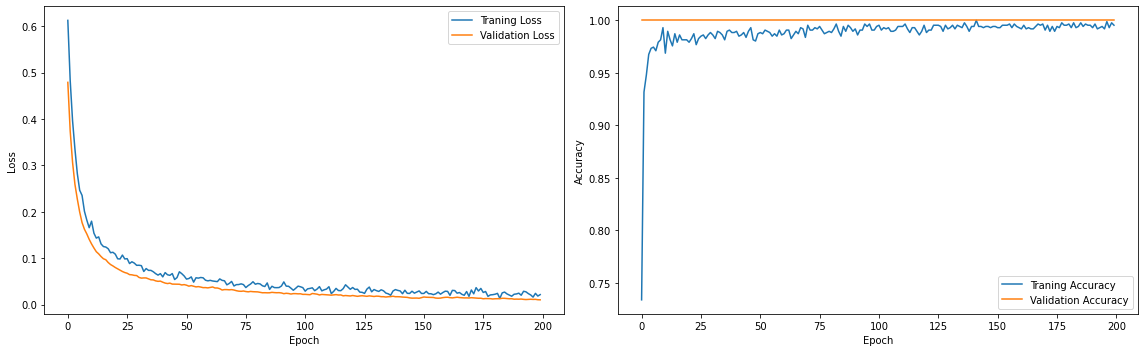

In [16]:
utils.visualize_loss_acc(training_loss_hist, valid_loss_hist, training_acc_hist, valid_acc_hist)

In [17]:
# Remove the model from VRAM
torch.save(model, 'saved_models/vgg_feature_extract.pt')
del model
torch.cuda.empty_cache()

### ResNet

In [18]:
# Initialize the model for this run
model = utils.initialize_model("resnet", num_classes, feature_extract, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss() # Setup the loss
params_to_update = utils.create_params_to_update(model, feature_extract)
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

# Print the model we just initialized
from pytorch_model_summary import summary
print( summary(model, torch.zeros((1, 3, 400, 400)).to(device), show_input=True) )

with open('ResNet_model.txt', 'w') as f:
    print(model, file=f)

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 400, 400]           9,408               0
          BatchNorm2d-2     [1, 64, 200, 200]             128               0
                 ReLU-3     [1, 64, 200, 200]               0               0
            MaxPool2d-4     [1, 64, 200, 200]               0               0
           BasicBlock-5     [1, 64, 100, 100]          73,984               0
           BasicBlock-6     [1, 64, 100, 100]          73,984               0
           BasicBlock-7     [1, 64, 100, 100]         230,144               0
           BasicBlock-8      [1, 128, 50, 50]         295,424               0
           BasicBlock-9      [1, 128, 50, 50]         919,040               0
          BasicBlock-10      [1, 256, 25, 25]       1,180,672               0
          BasicBlock-11      [1, 256, 25, 25]       3,673,088  

In [19]:
# Train and evaluate
training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist = utils.train(model,
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               optimizer, 
                                                                               criterion, 
                                                                               max_epoch=num_epochs, 
                                                                               device=device, 
                                                                               debug=False)

stats["resnet_feature_ext"] = (training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist)

epoch 199 train loss:0.10602 train acc:0.97917 val loss:0.39405 val acc:0.8125: 100%|████████████████████████████████████████████| 200/200 [26:58<00:00,  8.09s/it]

Time:  1618.735955768032


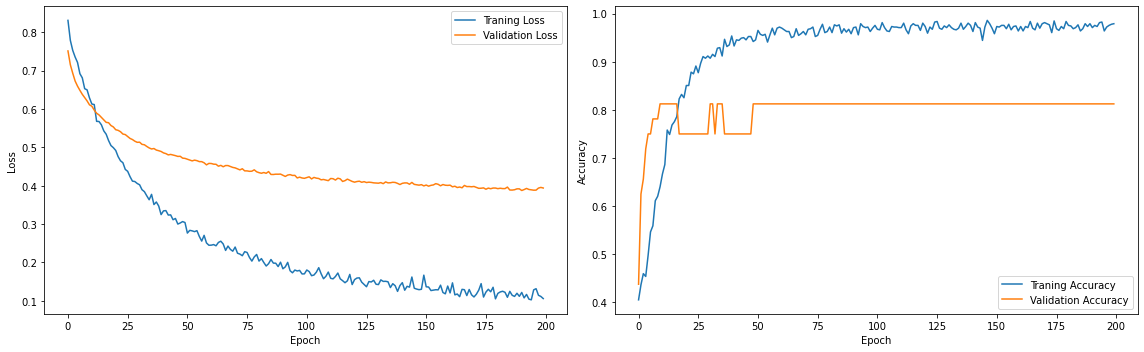

In [20]:
utils.visualize_loss_acc(training_loss_hist, valid_loss_hist, training_acc_hist, valid_acc_hist)

In [21]:
# Remove the model from VRAM
torch.save(model, 'saved_models/resnet_feature_extract.pt')
del model
torch.cuda.empty_cache()

### DenseNet

In [22]:
# Initialize the model for this run
model = utils.initialize_model("densenet", num_classes, feature_extract, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss() # Setup the loss
params_to_update = utils.create_params_to_update(model, feature_extract)
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

# Print the model we just initialized
from pytorch_model_summary import summary
print( summary(model, torch.zeros((1, 3, 400, 400)).to(device), show_input=True) )

with open('DenseNet_model.txt', 'w') as f:
    print(model, file=f)

--------------------------------------------------------------------------
      Layer (type)            Input Shape         Param #     Tr. Param #
          Conv2d-1       [1, 3, 400, 400]           9,408               0
     BatchNorm2d-2      [1, 64, 200, 200]             128               0
            ReLU-3      [1, 64, 200, 200]               0               0
       MaxPool2d-4      [1, 64, 200, 200]               0               0
     _DenseBlock-5      [1, 64, 100, 100]         335,040               0
     BatchNorm2d-6     [1, 256, 100, 100]             512               0
            ReLU-7     [1, 256, 100, 100]               0               0
          Conv2d-8     [1, 256, 100, 100]          32,768               0
       AvgPool2d-9     [1, 128, 100, 100]               0               0
    _DenseBlock-10       [1, 128, 50, 50]         919,680               0
    BatchNorm2d-11       [1, 512, 50, 50]           1,024               0
           ReLU-12       [1, 512, 50,

In [23]:
# Train and evaluate
training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist = utils.train(model,
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               optimizer, 
                                                                               criterion, 
                                                                               max_epoch=num_epochs, 
                                                                               device=device, 
                                                                               debug=False)

stats["densenet_feature_ext"] = (training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist)

epoch 199 train loss:0.10362 train acc:0.97106 val loss:0.4123 val acc:0.8125: 100%|█████████████████████████████████████████████| 200/200 [31:16<00:00,  9.38s/it]

Time:  1876.1333172820741


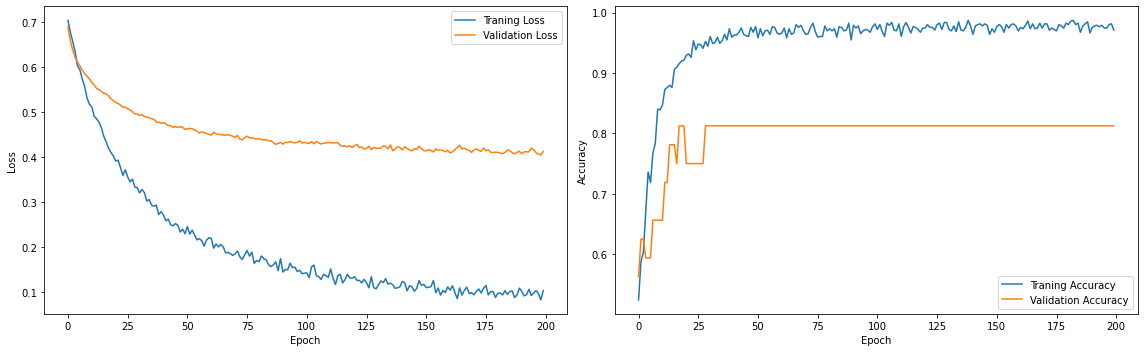

In [24]:
utils.visualize_loss_acc(training_loss_hist, valid_loss_hist, training_acc_hist, valid_acc_hist)

In [25]:
# Remove the model from VRAM
torch.save(model, 'saved_models/densenet_feature_extract.pt')
del model
torch.cuda.empty_cache()

## Experiments (Fine-Tuning)

In [26]:
# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = False

### VGG

In [27]:
# Initialize the model for this run
model = utils.initialize_model("vgg", num_classes, feature_extract, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss() # Setup the loss
params_to_update = utils.create_params_to_update(model, feature_extract)
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

# Print the model we just initialized
from pytorch_model_summary import summary
print( summary(model, torch.zeros((1, 3, 400, 400)).to(device), show_input=True) )

with open('VGG_model.txt', 'w') as f:
    print(model, file=f)

-------------------------------------------------------------------------------
           Layer (type)            Input Shape         Param #     Tr. Param #
               Conv2d-1       [1, 3, 400, 400]           1,792           1,792
          BatchNorm2d-2      [1, 64, 400, 400]             128             128
                 ReLU-3      [1, 64, 400, 400]               0               0
            MaxPool2d-4      [1, 64, 400, 400]               0               0
               Conv2d-5      [1, 64, 200, 200]          73,856          73,856
          BatchNorm2d-6     [1, 128, 200, 200]             256             256
                 ReLU-7     [1, 128, 200, 200]               0               0
            MaxPool2d-8     [1, 128, 200, 200]               0               0
               Conv2d-9     [1, 128, 100, 100]         295,168         295,168
         BatchNorm2d-10     [1, 256, 100, 100]             512             512
                ReLU-11     [1, 256, 100, 100]     

In [28]:
# Train and evaluate
training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist = utils.train(model,
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               optimizer, 
                                                                               criterion, 
                                                                               max_epoch=num_epochs, 
                                                                               device=device, 
                                                                               debug=False)

stats["vgg_finetuned"] = (training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist)

epoch 199 train loss:0.0003 train acc:1.0 val loss:0.00867 val acc:1.0: 100%|████████████████████████████████████████████████████| 200/200 [39:49<00:00, 11.95s/it]

Time:  2389.82272685098


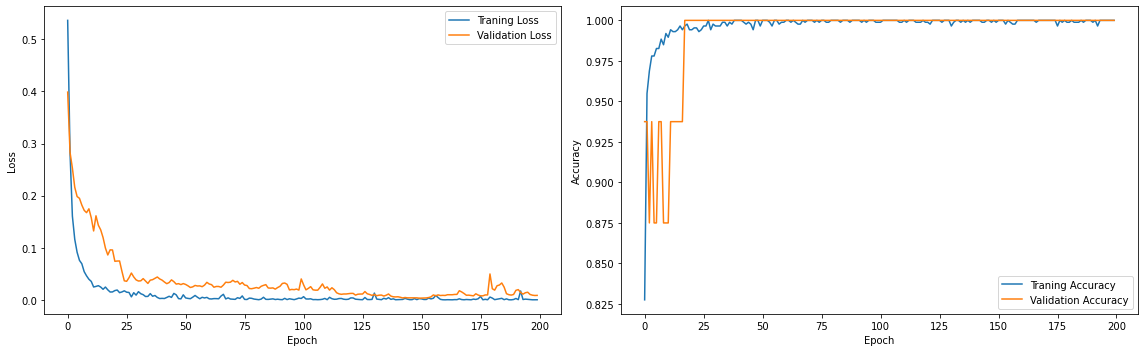

In [29]:
utils.visualize_loss_acc(training_loss_hist, valid_loss_hist, training_acc_hist, valid_acc_hist)

In [30]:
# Remove the model from VRAM
torch.save(model, 'saved_models/vgg_finetuned.pt')
del model
torch.cuda.empty_cache()

### ResNet

In [31]:
# Initialize the model for this run
model = utils.initialize_model("resnet", num_classes, feature_extract, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss() # Setup the loss
params_to_update = utils.create_params_to_update(model, feature_extract)
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

# Print the model we just initialized
from pytorch_model_summary import summary
print( summary(model, torch.zeros((1, 3, 400, 400)).to(device), show_input=True) )

with open('ResNet_model.txt', 'w') as f:
    print(model, file=f)

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 400, 400]           9,408           9,408
          BatchNorm2d-2     [1, 64, 200, 200]             128             128
                 ReLU-3     [1, 64, 200, 200]               0               0
            MaxPool2d-4     [1, 64, 200, 200]               0               0
           BasicBlock-5     [1, 64, 100, 100]          73,984          73,984
           BasicBlock-6     [1, 64, 100, 100]          73,984          73,984
           BasicBlock-7     [1, 64, 100, 100]         230,144         230,144
           BasicBlock-8      [1, 128, 50, 50]         295,424         295,424
           BasicBlock-9      [1, 128, 50, 50]         919,040         919,040
          BasicBlock-10      [1, 256, 25, 25]       1,180,672       1,180,672
          BasicBlock-11      [1, 256, 25, 25]       3,673,088  

In [32]:
# Train and evaluate
training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist = utils.train(model,
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               optimizer, 
                                                                               criterion, 
                                                                               max_epoch=num_epochs, 
                                                                               device=device, 
                                                                               debug=False)

stats["resnet_finetuned"] = (training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist)

epoch 199 train loss:0.00652 train acc:0.99884 val loss:0.21954 val acc:0.9375: 100%|████████████████████████████████████████████| 200/200 [31:04<00:00,  9.32s/it]

Time:  1864.3857557569863


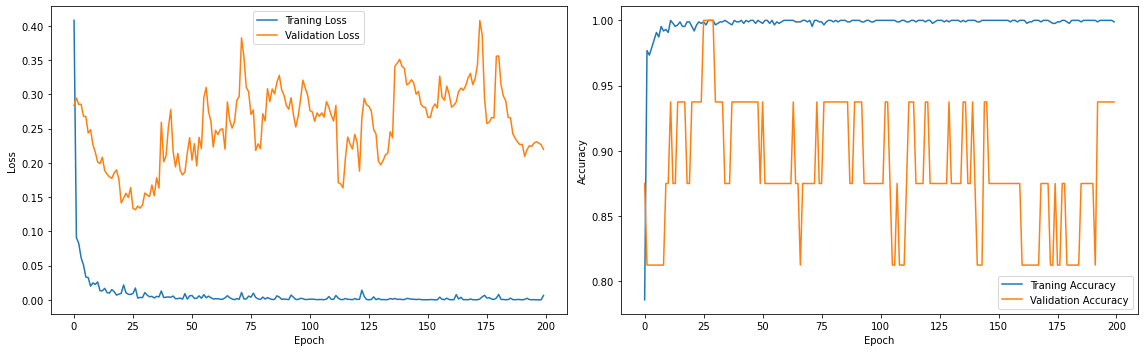

In [33]:
utils.visualize_loss_acc(training_loss_hist, valid_loss_hist, training_acc_hist, valid_acc_hist)

In [34]:
# Remove the model from VRAM
torch.save(model, 'saved_models/resnet_finetuned.pt')
del model
torch.cuda.empty_cache()

## DenseNet

In [35]:
# Initialize the model for this run
model = utils.initialize_model("densenet", num_classes, feature_extract, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss() # Setup the loss
params_to_update = utils.create_params_to_update(model, feature_extract)
optimizer = torch.optim.Adam(params_to_update, lr=0.00001)

# Print the model we just initialized
from pytorch_model_summary import summary
print( summary(model, torch.zeros((1, 3, 400, 400)).to(device), show_input=True) )

with open('DenseNet_model.txt', 'w') as f:
    print(model, file=f)

--------------------------------------------------------------------------
      Layer (type)            Input Shape         Param #     Tr. Param #
          Conv2d-1       [1, 3, 400, 400]           9,408           9,408
     BatchNorm2d-2      [1, 64, 200, 200]             128             128
            ReLU-3      [1, 64, 200, 200]               0               0
       MaxPool2d-4      [1, 64, 200, 200]               0               0
     _DenseBlock-5      [1, 64, 100, 100]         335,040         335,040
     BatchNorm2d-6     [1, 256, 100, 100]             512             512
            ReLU-7     [1, 256, 100, 100]               0               0
          Conv2d-8     [1, 256, 100, 100]          32,768          32,768
       AvgPool2d-9     [1, 128, 100, 100]               0               0
    _DenseBlock-10       [1, 128, 50, 50]         919,680         919,680
    BatchNorm2d-11       [1, 512, 50, 50]           1,024           1,024
           ReLU-12       [1, 512, 50,

In [36]:
# Train and evaluate
training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist = utils.train(model,
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               optimizer, 
                                                                               criterion, 
                                                                               max_epoch=num_epochs, 
                                                                               device=device, 
                                                                               debug=False)

stats["densenet_finetuned"] = (training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist)

epoch 199 train loss:0.00013 train acc:1.0 val loss:0.6484 val acc:0.75: 100%|███████████████████████████████████████████████████| 200/200 [47:51<00:00, 14.36s/it]

Time:  2871.749494393007


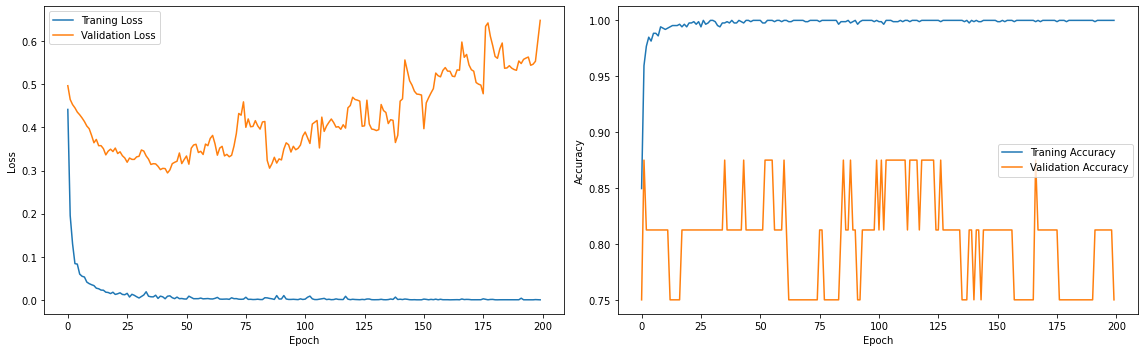

In [37]:
utils.visualize_loss_acc(training_loss_hist, valid_loss_hist, training_acc_hist, valid_acc_hist)

In [38]:
# Remove the model from VRAM
torch.save(model, 'saved_models/densenet_finetuned.pt')
del model
torch.cuda.empty_cache()

## Resnet + Cutmix

Finetuning all weights from Resnet.

In [39]:
# used implementation: https://github.com/hysts/pytorch_cutmix
!wget -q --show-progress https://raw.githubusercontent.com/hysts/pytorch_cutmix/master/cutmix.py -O cutmix.py

cutmix.py           100%[===================>]   1,31K  --.-KB/s    in 0s      


In [40]:
from cutmix import CutMixCriterion, CutMixCollator

criterion = CutMixCriterion(reduction='mean') # use this as same as nn.CrossEntropyLoss
collator = CutMixCollator(alpha = 1.0) # alpha: default cutmix alpha value is 1.0

train_dataset_cutmix = Dataset(root_dir=TRAIN_DATA_DIR, transform=data_transforms["train_cutmix"])

cutmix_loader = torch.utils.data.DataLoader(
    train_dataset_cutmix,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collator,   # <============== !!!
    pin_memory=True,
    drop_last=True,
)

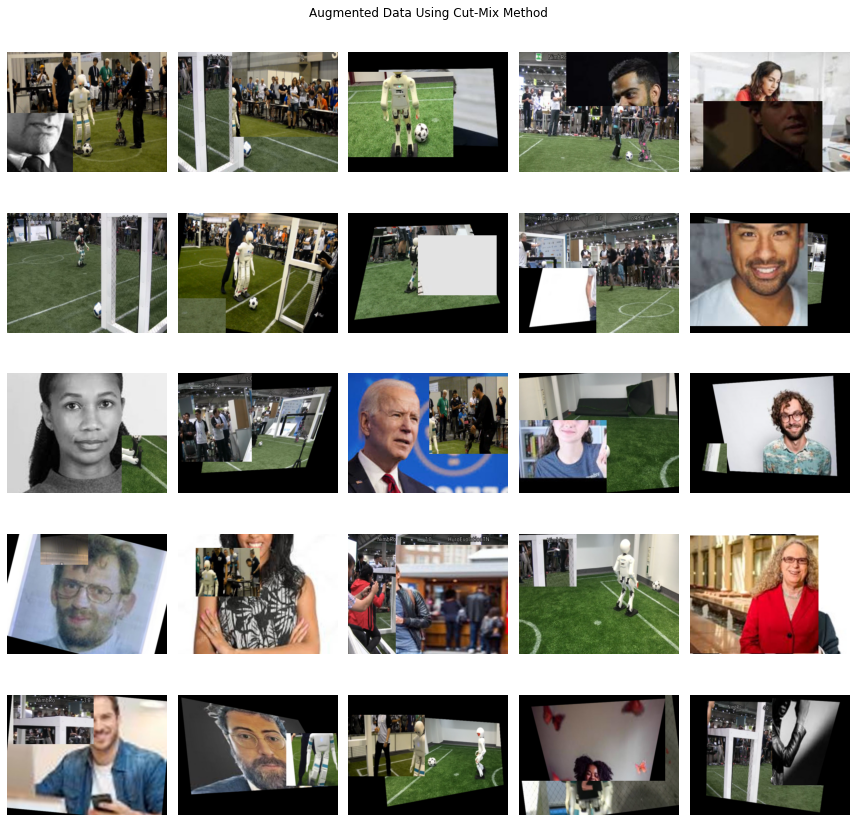

In [41]:
fig, axs = plt.subplots(5,5, figsize=(12,12))
axs = np.array(axs).flatten().tolist()

for idx, (img, label) in enumerate(cutmix_loader):
    if idx==25:
        break
    axs[idx].imshow(img[0].permute(1,2,0))
    axs[idx].axis('off')
    
fig.suptitle("Augmented Data Using Cut-Mix Method")  
fig.tight_layout()

In [44]:
# Initialize the model for this run
model = utils.initialize_model("resnet", num_classes, feature_extract=False, use_pretrained=True).to(device)
# criterion = nn.CrossEntropyLoss() # Using cut-mix version instead of this one!!!
params_to_update = utils.create_params_to_update(model, feature_extract=False, debug=False)
optimizer = torch.optim.Adam(params_to_update, lr=0.000001)

# Print the model we just initialized
from pytorch_model_summary import summary
print( summary(model, torch.zeros((1, 3, 400, 400)).to(device), show_input=True) )
#print(model)  #prints the model in detail

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 400, 400]           9,408           9,408
          BatchNorm2d-2     [1, 64, 200, 200]             128             128
                 ReLU-3     [1, 64, 200, 200]               0               0
            MaxPool2d-4     [1, 64, 200, 200]               0               0
           BasicBlock-5     [1, 64, 100, 100]          73,984          73,984
           BasicBlock-6     [1, 64, 100, 100]          73,984          73,984
           BasicBlock-7     [1, 64, 100, 100]         230,144         230,144
           BasicBlock-8      [1, 128, 50, 50]         295,424         295,424
           BasicBlock-9      [1, 128, 50, 50]         919,040         919,040
          BasicBlock-10      [1, 256, 25, 25]       1,180,672       1,180,672
          BasicBlock-11      [1, 256, 25, 25]       3,673,088  

In [45]:
train_epochs = []
train_loss = []
val_epochs = []
val_acc = []

train_batches = len(cutmix_loader)
val_batches = len(val_loader)

with tqdm(total=(train_batches+val_batches)*num_epochs) as pbar:
    for e in range(num_epochs):
        for idx, (img, label) in enumerate(cutmix_loader):
            out = model(img.to(device))

            t1,t2,lam = label
            label = t1.to(device), t2.to(device), lam
            loss = criterion(out, label)

            pbar.update(1)
            train_epochs.append(e + idx/train_batches)
            train_loss.append(loss.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

        for idx, (img, label) in enumerate(val_loader):
            out = model(img.to(device))

            pbar.update(1)
            val_epochs.append(e + idx/val_batches)
            acc = np.mean( np.argmax( out.detach().cpu().numpy(), axis=1 ) == label.numpy() )
            val_acc.append(acc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11200/11200 [13:25<00:00, 13.90it/s]


In [46]:
stats["resnet_cutmix"] = (train_loss, None, None, val_acc)

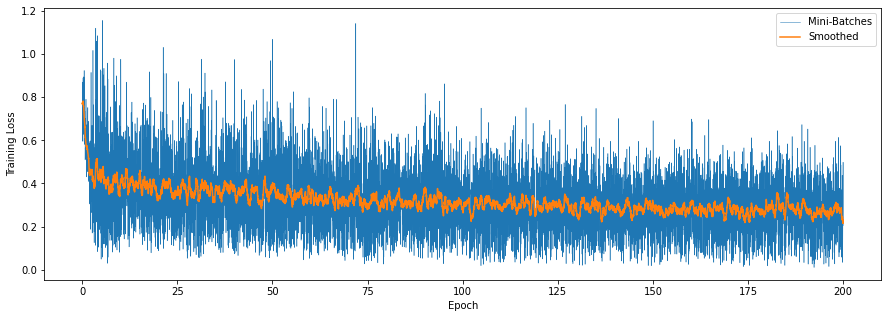

In [48]:
plt.figure(figsize=(15,5))
_=plt.plot(train_epochs, train_loss, linewidth=0.5, label="Mini-Batches")
_=plt.plot(train_epochs, utils.smooth(train_loss, 31), label="Smoothed")
_=plt.xlabel("Epoch")
_=plt.ylabel("Training Loss")
_=plt.legend()

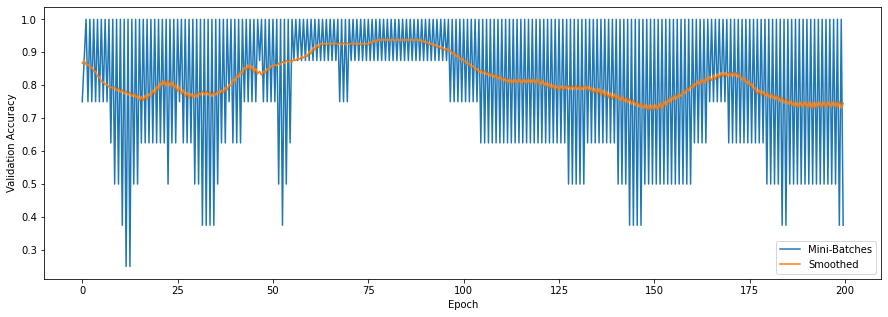

In [49]:
plt.figure(figsize=(15,5))
_=plt.plot(val_epochs, val_acc, label="Mini-Batches")
_=plt.plot(val_epochs, utils.smooth(val_acc, 31), label="Smoothed")
_=plt.xlabel("Epoch")
_=plt.ylabel("Validation Accuracy")
_=plt.legend()

In [50]:
# Remove the model from VRAM
torch.save(model, 'saved_models/resnet_cutmix.pt')
del model
torch.cuda.empty_cache()

## Resnet + SVC

### Extract Resnet Intermediate Activations

In [51]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True).to(device)

# source: https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/2
activation = {}
def get_activation(model, name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
resnet18.avgpool.register_forward_hook(get_activation(resnet18, 'avgpool'))

how_many_times = 5 # Sampling # times to use data augmentations benefits

resnet_dataset_x = []
resnet_dataset_y = []

with tqdm(total=len(train_loader)*how_many_times) as pbar:
    for e in range(how_many_times):
        with torch.no_grad():
            for s in train_loader:
                img, label = s
                output = resnet18(img.to(device))
                #print(activation['avgpool'].shape)

                resnet_dataset_x.append(activation['avgpool'].detach().cpu().numpy())
                resnet_dataset_y.append(label.detach().cpu().numpy())

                pbar.update(1)
        
resnet_dataset_x = np.stack(resnet_dataset_x)
resnet_dataset_y = np.stack(resnet_dataset_y)

resnet_dataset_x = resnet_dataset_x.reshape((-1, resnet_dataset_x.shape[2]))
resnet_dataset_y = resnet_dataset_y.flatten()

print("resnet_dataset_x.shape:", resnet_dataset_x.shape)
print("resnet_dataset_y.shape", resnet_dataset_y.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:42<00:00,  6.34it/s]

resnet_dataset_x.shape: (4320, 512)
resnet_dataset_y.shape (4320,)


### Train an SVM Model

In [52]:
from sklearn import svm

clf_linear = svm.SVC(kernel="linear")
clf_linear.fit(resnet_dataset_x, resnet_dataset_y)

clf_poly = svm.SVC(kernel="poly")
clf_poly.fit(resnet_dataset_x, resnet_dataset_y)

clf_rbf = svm.SVC(kernel="rbf")
clf_rbf.fit(resnet_dataset_x, resnet_dataset_y)

clf_sigmoid = svm.SVC(kernel="sigmoid")
clf_sigmoid.fit(resnet_dataset_x, resnet_dataset_y)

SVC(kernel='sigmoid')

### Combine Resnet and SVM in One Class

In [53]:
class ResnetSVC():
    def __init__(self, resnet_model, svc_model):
        self.resnet_model = resnet_model
        self.svc_model = svc_model
        
        self.activation = {}
        def get_activation(model, name):
            def hook(model, input, output):
                self.activation[name] = output.detach()
            return hook
        self.resnet_model.avgpool.register_forward_hook(get_activation(self.resnet_model, 'avgpool'))
    
    def __call__(self, x):
        # RESNET PART
        with torch.no_grad():
            self.resnet_model(x)
        resnet_intermediate_output = self.activation["avgpool"].detach().cpu().numpy()
        
        # SVC PART
        resnet_intermediate_output = resnet_intermediate_output.reshape((-1, 512))
        svc_output = self.svc_model.predict(resnet_intermediate_output)
        
        return svc_output
    
def resnetsvc_results(resnetsvc, train_loader, val_loader):
    train_results = []
    for s in train_loader:
        img, label = s
        output = resnetsvc(img.to(device)) 
        result = np.mean(output == label.numpy().flatten())
        train_results.append(result)

    val_results = []
    for s in val_loader:
        img, label = s
        output = resnetsvc(img.to(device)) 
        result = np.mean(output == label.numpy().flatten())
        val_results.append(result)

    print("Training Accuracy:", np.mean(train_results))
    print("Validation Accuracy:", np.mean(val_results))

In [54]:
print("Using linear kernel SVC:")
resnetsvc = ResnetSVC(resnet18, clf_linear)
resnetsvc_results(resnetsvc, train_loader, val_loader)

print("\nUsing poly kernel SVC:")
resnetsvc = ResnetSVC(resnet18, clf_poly)
resnetsvc_results(resnetsvc, train_loader, val_loader)

print("\nUsing rbf kernel SVC:")
resnetsvc = ResnetSVC(resnet18, clf_rbf)
resnetsvc_results(resnetsvc, train_loader, val_loader)

print("\nUsing sigmoid kernel SVC:")
resnetsvc = ResnetSVC(resnet18, clf_sigmoid)
resnetsvc_results(resnetsvc, train_loader, val_loader)

Using linear kernel SVC:
Training Accuracy: 0.9861111111111112
Validation Accuracy: 0.75

Using poly kernel SVC:
Training Accuracy: 0.9942129629629629
Validation Accuracy: 0.8125

Using rbf kernel SVC:
Training Accuracy: 0.9918981481481481
Validation Accuracy: 0.9375

Using sigmoid kernel SVC:
Training Accuracy: 0.6261574074074074
Validation Accuracy: 0.4375


## Comparison & Discussion

- Regarding the dataset, all the robot images are taken in the football arena. Therefore, the model may not identify a human in the football stadium as a human. More data, e.g. including robot images having different backgrounds and human images in the football arena, are needed to overcome this problem. Moreover, it is possible to modify hue values to prevent the model from learning the green color of the football arena. However, it still has many features except the coloring. Example inferences for this discussion are given below the discussion part.

- For the small number of grayscale images in the dataset, since the input should contain 3 channels, grayscale channels were copied to RGB channels to keep these samples in the dataset.

- For the transfer learning part, the performance of VGG is good. Other networks, ResNet and DenseNet, overfit the training data. In terms of validation accuracy, ResNet was more successful than DenseNet.

- Although the training loss of ResNet & CutMix was worse compared to the models with transfer learning, they achieved better validation accuracies than some of them.

- For the experiment of ResNet+SVM, RBF kernel worked best followed by the polynomial kernel. Linear kernel performance can be considered good. However, sigmoid was the worst one among them.

- Training and validation losses of feature extraction is more smooth compared to fine-tuning. But the validation accuracies are generally better with fine-tuning.

In [57]:
# Smooth resnet_cutmix stats
train_loss, _, _, val_acc = stats["resnet_cutmix"]
stats["resnet_cutmix"] = (utils.smooth(train_loss, 31), None, None, utils.smooth(val_acc, 31) )

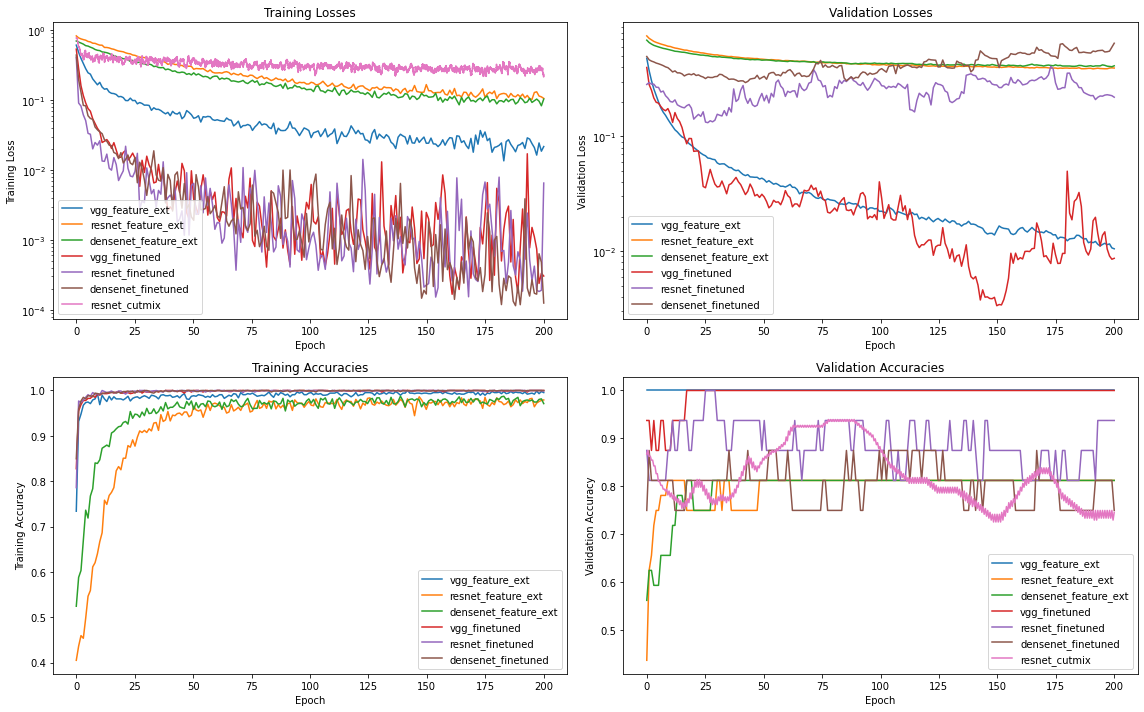

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 10))
for experiment, (training_loss_hist, training_acc_hist, valid_loss_hist, valid_acc_hist) in stats.items():
    if training_loss_hist is not None:
        ax1.plot(np.linspace(0, num_epochs, len(training_loss_hist)), 
                             training_loss_hist, label=experiment)
    if valid_loss_hist is not None:
        ax2.plot(np.linspace(0, num_epochs, len(valid_loss_hist)), 
                             valid_loss_hist, label=experiment)
    if training_acc_hist is not None:
        ax3.plot(np.linspace(0, num_epochs, len(training_acc_hist)), 
                             training_acc_hist, label=experiment)
    if valid_acc_hist is not None:
        ax4.plot(np.linspace(0, num_epochs, len(valid_acc_hist)), 
                             valid_acc_hist, label=experiment)

ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_title("Training Losses")
ax2.set_title("Validation Losses")
ax3.set_title("Training Accuracies")
ax4.set_title("Validation Accuracies")
ax1.set_ylabel("Training Loss")
ax2.set_ylabel("Validation Loss")
ax3.set_ylabel("Training Accuracy")
ax4.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax3.set_xlabel("Epoch")
ax4.set_xlabel("Epoch")
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
    
fig.tight_layout()

In [60]:
model = torch.load("saved_models/vgg_finetuned.pt")

football_player.jpg 100%[===================>]   5,07M   721KB/s    in 7,6s    
Human: 0.1195402443408966 Robot: 0.8804597854614258


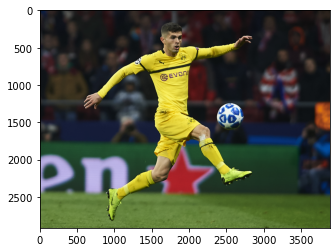

In [61]:
!wget -q --show-progress https://media.npr.org/assets/img/2019/01/02/gettyimages-1058306908-0b38ff8a90d7bf88fea3133d8b72498665f63e12.jpg -O football_player.jpg
    
img = Image.open("football_player.jpg")
_=plt.imshow(img)

out = model(data_transforms["val"](img).unsqueeze(0).to(device))
s_out = torch.nn.functional.softmax(out, dim=1)
print("Human: {} Robot: {}".format(s_out[0,0], s_out[0,1]))

person.jpg          100%[===================>] 242,46K   903KB/s    in 0,3s    
Human: 0.9372997879981995 Robot: 0.06270020455121994


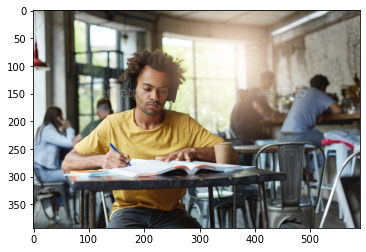

In [62]:
!wget -q --show-progress https://s3.envato.com/files/323029531/envato01365.jpg -O person.jpg
    
img = Image.open("person.jpg")
_=plt.imshow(img)

out = model(data_transforms["val"](img).unsqueeze(0).to(device))
s_out = torch.nn.functional.softmax(out, dim=1)
print("Human: {} Robot: {}".format(s_out[0,0], s_out[0,1]))

robot.jpg           100%[===================>]   3,65M  20,6MB/s    in 0,2s    
Human: 0.9162756204605103 Robot: 0.08372434973716736


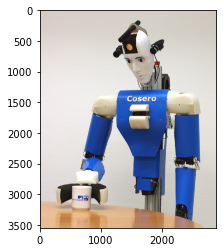

In [63]:
!wget -q --show-progress http://www.nimbro.net/@Home/images/robots/Cosero/Cosero_Cup_upper.jpg -O robot.jpg
    
img = Image.open("robot.jpg")
_=plt.imshow(img)

out = model(data_transforms["val"](img).unsqueeze(0).to(device))
s_out = torch.nn.functional.softmax(out, dim=1)
print("Human: {} Robot: {}".format(s_out[0,0], s_out[0,1]))

## References

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html